# Understanding EWMA and Its Role in RMSProp and Adam Optimizers

This notebook explores the concept of Exponentially Weighted Moving Average (EWMA) and demonstrates how it's used in modern optimization algorithms like RMSProp and Adam.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

plt.style.use('seaborn-v0_8-darkgrid')
np.random.seed(42)

## 1. What is EWMA (Exponentially Weighted Moving Average)?

EWMA is a method for smoothing time-series data by giving exponentially decreasing weights to older observations.

### Mathematical Definition:

Given a sequence of values $x_1, x_2, ..., x_t$, the EWMA at time $t$ is:

$$v_t = \beta v_{t-1} + (1 - \beta) x_t$$

where:
- $v_t$ is the EWMA at time $t$
- $\beta$ is the decay rate (typically between 0.9 and 0.999)
- $x_t$ is the current observation
- $v_0 = 0$ (initial value)

### Key Properties:
- Higher $\beta$ → more smoothing (slower adaptation)
- Lower $\beta$ → less smoothing (faster adaptation)
- The EWMA approximately averages over $\frac{1}{1-\beta}$ observations

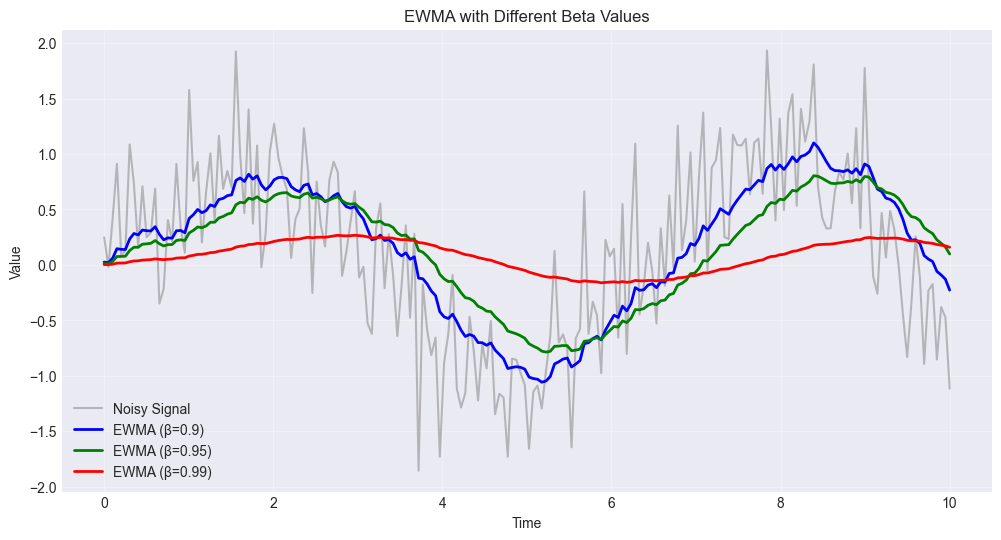

In [2]:
def compute_ewma(data, beta):
    """Compute EWMA for a given sequence."""
    v = 0
    ewma_values = []
    
    for x in data:
        v = beta * v + (1 - beta) * x
        ewma_values.append(v)
    
    return np.array(ewma_values)

# Generate noisy data
t = np.linspace(0, 10, 200)
signal = np.sin(t) + 0.5 * np.random.randn(len(t))

# Compute EWMA with different beta values
ewma_09 = compute_ewma(signal, beta=0.9)
ewma_095 = compute_ewma(signal, beta=0.95)
ewma_099 = compute_ewma(signal, beta=0.99)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(t, signal, 'gray', alpha=0.5, label='Noisy Signal')
plt.plot(t, ewma_09, 'b-', linewidth=2, label='EWMA (β=0.9)')
plt.plot(t, ewma_095, 'g-', linewidth=2, label='EWMA (β=0.95)')
plt.plot(t, ewma_099, 'r-', linewidth=2, label='EWMA (β=0.99)')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('EWMA with Different Beta Values')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 2. Bias Correction in EWMA

Since $v_0 = 0$, the initial EWMA values are biased toward zero. We correct this with:

$$\hat{v}_t = \frac{v_t}{1 - \beta^t}$$

This correction is particularly important in the early iterations.

In [ ]:
def compute_ewma_with_bias_correction(data, beta):
    """Compute EWMA with bias correction."""
    v = 0
    ewma_values = []
    ewma_corrected = []
    
    for t, x in enumerate(data, 1):
        v = beta * v + (1 - beta) * x
        v_corrected = v / (1 - beta**t)
        ewma_values.append(v)
        ewma_corrected.append(v_corrected)
    
    return np.array(ewma_values), np.array(ewma_corrected)

# Generate constant signal with noise
constant_signal = 5 + 0.5 * np.random.randn(50)
ewma_raw, ewma_corrected = compute_ewma_with_bias_correction(constant_signal, beta=0.9)

plt.figure(figsize=(12, 6))
plt.plot(constant_signal, 'o', alpha=0.5, label='Data')
plt.plot(ewma_raw, 'r-', linewidth=2, label='EWMA (without correction)')
plt.plot(ewma_corrected, 'g-', linewidth=2, label='EWMA (with bias correction)')
plt.axhline(y=5, color='k', linestyle='--', alpha=0.5, label='True mean')
plt.xlabel('Iteration')
plt.ylabel('Value')
plt.title('Effect of Bias Correction in EWMA')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 3. RMSProp Optimizer

RMSProp (Root Mean Square Propagation) uses EWMA to adapt the learning rate for each parameter.

### Algorithm:

1. Initialize: $s = 0$
2. At iteration $t$:
   - Compute gradient: $g_t = \nabla_\theta J(\theta)$
   - Update EWMA of squared gradients: $s_t = \beta s_{t-1} + (1-\beta) g_t^2$
   - Update parameters: $\theta_{t+1} = \theta_t - \frac{\alpha}{\sqrt{s_t + \epsilon}} g_t$

where $\alpha$ is the learning rate and $\epsilon$ is a small constant (e.g., $10^{-8}$) for numerical stability.

### Key Insight:
Parameters with large gradients get smaller effective learning rates, while parameters with small gradients get larger effective learning rates.

In [3]:
def rmsprop(gradient_fn, x0, learning_rate=0.01, beta=0.9, epsilon=1e-8, n_iter=100):
    """RMSProp optimizer implementation."""
    x = x0.copy()
    s = np.zeros_like(x)
    history = [x.copy()]
    
    for i in range(n_iter):
        g = gradient_fn(x)
        s = beta * s + (1 - beta) * g**2
        x = x - learning_rate * g / (np.sqrt(s) + epsilon)
        history.append(x.copy())
    
    return np.array(history)

# Define a simple 2D function to optimize: f(x, y) = x^2 + 10*y^2
def f(x):
    return x[0]**2 + 10*x[1]**2

def gradient_f(x):
    return np.array([2*x[0], 20*x[1]])

# Starting point
x0 = np.array([5.0, 5.0])

# Run RMSProp
rmsprop_path = rmsprop(gradient_f, x0, learning_rate=0.1, beta=0.9, n_iter=50)

## 4. Adam Optimizer

Adam (Adaptive Moment Estimation) combines two EWMAs:
1. EWMA of gradients (momentum)
2. EWMA of squared gradients (like RMSProp, size)

### Algorithm:

1. Initialize: $m = 0$, $v = 0$
2. At iteration $t$:
   - Compute gradient: $g_t = \nabla_\theta J(\theta)$
   - Update biased first moment: $m_t = \beta_1 m_{t-1} + (1-\beta_1) g_t$
   - Update biased second moment: $v_t = \beta_2 v_{t-1} + (1-\beta_2) g_t^2$
   - Bias correction: $\hat{m}_t = \frac{m_t}{1-\beta_1^t}$, $\hat{v}_t = \frac{v_t}{1-\beta_2^t}$
   - Update parameters: $\theta_{t+1} = \theta_t - \frac{\alpha \hat{m}_t}{\sqrt{\hat{v}_t} + \epsilon}$

Typical values: $\beta_1 = 0.9$, $\beta_2 = 0.999$, $\alpha = 0.001$

In [5]:
def adam(gradient_fn, x0, learning_rate=0.01, beta1=0.9, beta2=0.999, epsilon=1e-8, n_iter=100):
    """Adam optimizer implementation."""
    x = x0.copy()
    m = np.zeros_like(x)
    v = np.zeros_like(x)
    history = [x.copy()]
    
    for t in range(1, n_iter + 1):
        g = gradient_fn(x)
        
        # Update biased moments
        m = beta1 * m + (1 - beta1) * g
        v = beta2 * v + (1 - beta2) * g**2
        
        # Bias correction
        m_hat = m / (1 - beta1**t)
        v_hat = v / (1 - beta2**t)
        
        # Update parameters
        x = x - learning_rate * m_hat / (np.sqrt(v_hat) + epsilon)
        history.append(x.copy())
    
    return np.array(history)

# Run Adam
adam_path = adam(gradient_f, x0, learning_rate=0.1, beta1=0.9, beta2=0.999, n_iter=50)

## 5. Comparing SGD, RMSProp, and Adam

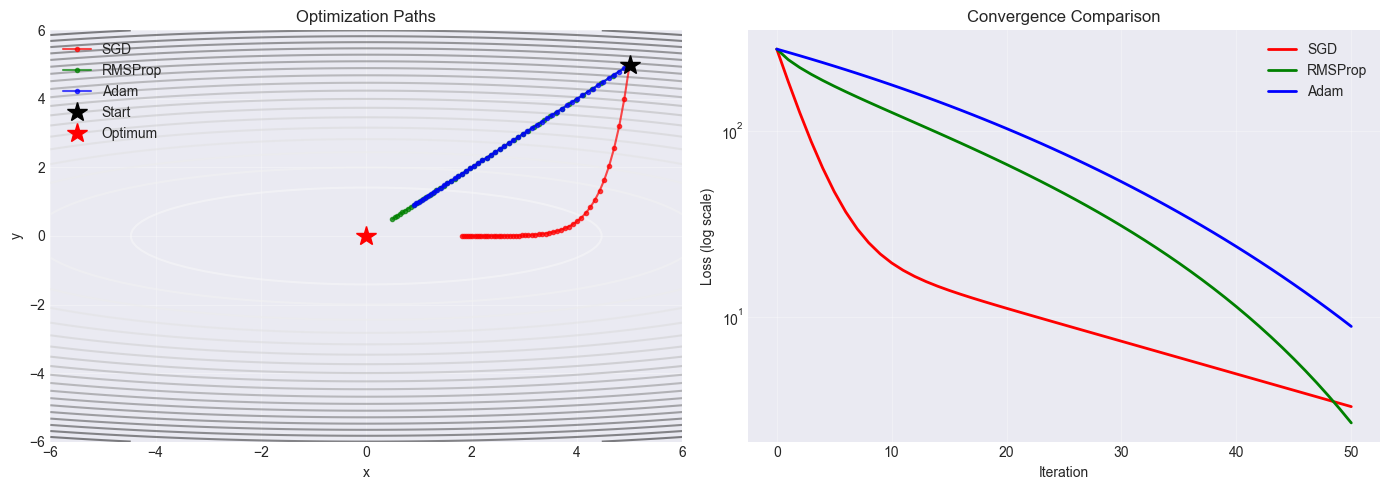

In [6]:
def sgd(gradient_fn, x0, learning_rate=0.01, n_iter=100):
    """Standard gradient descent."""
    x = x0.copy()
    history = [x.copy()]
    
    for i in range(n_iter):
        g = gradient_fn(x)
        x = x - learning_rate * g
        history.append(x.copy())
    
    return np.array(history)

# Run all optimizers
sgd_path = sgd(gradient_f, x0, learning_rate=0.01, n_iter=50)
rmsprop_path = rmsprop(gradient_f, x0, learning_rate=0.1, beta=0.9, n_iter=50)
adam_path = adam(gradient_f, x0, learning_rate=0.1, beta1=0.9, beta2=0.999, n_iter=50)

# Create contour plot
x_range = np.linspace(-6, 6, 100)
y_range = np.linspace(-6, 6, 100)
X, Y = np.meshgrid(x_range, y_range)
Z = X**2 + 10*Y**2

plt.figure(figsize=(14, 5))

# Plot contours and paths
plt.subplot(1, 2, 1)
plt.contour(X, Y, Z, levels=20, alpha=0.5)
plt.plot(sgd_path[:, 0], sgd_path[:, 1], 'ro-', label='SGD', markersize=3, alpha=0.7)
plt.plot(rmsprop_path[:, 0], rmsprop_path[:, 1], 'go-', label='RMSProp', markersize=3, alpha=0.7)
plt.plot(adam_path[:, 0], adam_path[:, 1], 'bo-', label='Adam', markersize=3, alpha=0.7)
plt.plot(x0[0], x0[1], 'k*', markersize=15, label='Start')
plt.plot(0, 0, 'r*', markersize=15, label='Optimum')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Optimization Paths')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot convergence
plt.subplot(1, 2, 2)
sgd_loss = [f(x) for x in sgd_path]
rmsprop_loss = [f(x) for x in rmsprop_path]
adam_loss = [f(x) for x in adam_path]

plt.semilogy(sgd_loss, 'r-', label='SGD', linewidth=2)
plt.semilogy(rmsprop_loss, 'g-', label='RMSProp', linewidth=2)
plt.semilogy(adam_loss, 'b-', label='Adam', linewidth=2)
plt.xlabel('Iteration')
plt.ylabel('Loss (log scale)')
plt.title('Convergence Comparison')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Visualizing EWMA Components in Adam

In [ ]:
def adam_with_history(gradient_fn, x0, learning_rate=0.01, beta1=0.9, beta2=0.999, epsilon=1e-8, n_iter=100):
    """Adam with full history tracking."""
    x = x0.copy()
    m = np.zeros_like(x)
    v = np.zeros_like(x)
    
    x_hist = [x.copy()]
    m_hist = [m.copy()]
    v_hist = [v.copy()]
    g_hist = []
    
    for t in range(1, n_iter + 1):
        g = gradient_fn(x)
        g_hist.append(g.copy())
        
        m = beta1 * m + (1 - beta1) * g
        v = beta2 * v + (1 - beta2) * g**2
        
        m_hat = m / (1 - beta1**t)
        v_hat = v / (1 - beta2**t)
        
        x = x - learning_rate * m_hat / (np.sqrt(v_hat) + epsilon)
        
        x_hist.append(x.copy())
        m_hist.append(m.copy())
        v_hist.append(v.copy())
    
    return np.array(x_hist), np.array(m_hist), np.array(v_hist), np.array(g_hist)

# Run Adam with history
x_hist, m_hist, v_hist, g_hist = adam_with_history(
    gradient_f, x0, learning_rate=0.1, n_iter=50
)

# Plot the EWMA components
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Gradients (x-dimension)
axes[0, 0].plot(g_hist[:, 0], 'gray', alpha=0.5, label='Gradient')
axes[0, 0].plot(m_hist[1:, 0], 'b-', linewidth=2, label='EWMA of gradient (m)')
axes[0, 0].set_xlabel('Iteration')
axes[0, 0].set_ylabel('Value')
axes[0, 0].set_title('First Moment (Momentum) - x dimension')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Gradients (y-dimension)
axes[0, 1].plot(g_hist[:, 1], 'gray', alpha=0.5, label='Gradient')
axes[0, 1].plot(m_hist[1:, 1], 'b-', linewidth=2, label='EWMA of gradient (m)')
axes[0, 1].set_xlabel('Iteration')
axes[0, 1].set_ylabel('Value')
axes[0, 1].set_title('First Moment (Momentum) - y dimension')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Squared gradients (x-dimension)
axes[1, 0].plot(g_hist[:, 0]**2, 'gray', alpha=0.5, label='Squared gradient')
axes[1, 0].plot(v_hist[1:, 0], 'r-', linewidth=2, label='EWMA of squared gradient (v)')
axes[1, 0].set_xlabel('Iteration')
axes[1, 0].set_ylabel('Value')
axes[1, 0].set_title('Second Moment (Adaptive LR) - x dimension')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Squared gradients (y-dimension)
axes[1, 1].plot(g_hist[:, 1]**2, 'gray', alpha=0.5, label='Squared gradient')
axes[1, 1].plot(v_hist[1:, 1], 'r-', linewidth=2, label='EWMA of squared gradient (v)')
axes[1, 1].set_xlabel('Iteration')
axes[1, 1].set_ylabel('Value')
axes[1, 1].set_title('Second Moment (Adaptive LR) - y dimension')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Summary

### EWMA's Role in Optimizers:

1. **RMSProp**: Uses EWMA of squared gradients to adapt learning rates
   - Reduces learning rate for dimensions with large gradients
   - Increases learning rate for dimensions with small gradients
   - Helps with ill-conditioned optimization problems

2. **Adam**: Combines two EWMAs
   - **First moment** (β₁ ≈ 0.9): EWMA of gradients → momentum effect
   - **Second moment** (β₂ ≈ 0.999): EWMA of squared gradients → adaptive learning rates
   - Bias correction ensures proper initialization

### Key Advantages:
- Automatic learning rate adaptation per parameter
- Robust to hyperparameter choices
- Handles sparse gradients well
- Faster convergence on many problems

### When to Use:
- **Adam**: Default choice for most deep learning tasks
- **RMSProp**: Good for RNNs and non-stationary problems
- **SGD with momentum**: When you need the best final performance and can tune carefully